# 0. Imports

In [1]:
# Imports
from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import scipy.stats as stats

# PySim
import SimFunctions
import SimRNG 
import SimClasses

# Plotting Libraries
import matplotlib.pyplot as plt
import plotly.express as px
mapbox_access_token = 'pk.eyJ1IjoicHNwZWx0IiwiYSI6ImNqdW4xemNtYzB3ZDI0ZXM4Z2VkYWwwMTgifQ.UodsHknkt8fNv3Viszo1Zg'
px.set_mapbox_access_token(mapbox_access_token)

# Weather Data Libraries
! pip install wetterdienst
from wetterdienst import Wetterdienst

     |████████████████████████████████| 153kB 5.2MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 757kB 6.9MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 122kB 11.1MB/s 
     |████████████████████████████████| 9.9MB 9.6MB/s 
     |████████████████████████████████| 27.4MB 155kB/s 
     |████████████████████████████████| 5.5MB 37.5MB/s 
     |████████████████████████████████| 286kB 29.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 112kB 34.9MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp37-none-any.whl size=61085 sha256=3ba483a6aa5795c45d5d83ba365f7af4d2f17047a43d4aec56e401d8f432d84e
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
  Created wheel for reques

# 1. Data Loading and Function Definitions

## 1.1 Population Data and Sampling

In [2]:
# Read Toronto Dissemination Tract Population (Population in 2016 by Lat-Long)
pop = pd.read_csv("db_pop_2016.csv",encoding='latin-1')#("toronto_db.csv")
# Filter on Toronto Area and Group on Unique Lat-Long
pop = pop.loc[pop.name5=="Toronto"][['pop_2016','lat','long']].copy()
pop = pop.groupby(by=['lat','long'])['pop_2016'].sum().reset_index()
# Convert Pandas to Numpy Array (Sampling w Numpy is ~10x Faster than Dataframe Sampling w Pandas)
pop = pop[['lat','long','pop_2016']].values
# Pull Lat-Longs from Array
pop_latlong = [tuple(x[:2]) for x in pop]
# Sum Total Pop From Array
tot_pop = np.sum(pop[:,2])
# Calculate Probability of Lat-Long (Pop / Tot Pop)
pop_p = np.array([x[2]/tot_pop for x in pop])
# Create Index to Sample From
pop_idx = np.arange(0,len(pop))
# Function uses numpy random choice to sample coordinates weighted by population
def sample_geo(pop=pop):
    return pop_latlong[np.random.choice(pop_idx,p=pop_p)]
# Plot Population
#fig = px.scatter_mapbox(pd.DataFrame(pop,columns=['lat','long','pop_2016']),lat='lat',lon='long',color='pop_2016',zoom=12,width=1000,height=1000)
#fig.show()

## 1.2 Distance and Bearing Calculations

In [3]:
def haversine(latlong1, latlong2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = latlong1[1]
    lat1 = latlong1[0]
    lon2 = latlong2[1]
    lat2 = latlong2[0]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Test Distance Calc Between Distribution Center (dc) and sampled latlong
test_latlong = sample_geo()
dc = np.array([43.74767,-79.40574])
haversine(test_latlong,dc)

# Mean Distance
dist = []
for x in np.arange(0,int(10e4)):
    dist.append(haversine(sample_geo(),dc))
np.mean(dist)

def calc_bearing_off_N(latlong1, latlong2):
    """
    Function calculates the bearing in degrees from North (where North is 0, East 90, South 180, West 270 etc.)
    """
    dlong = latlong2[1] - latlong1[1]
    X = np.cos(latlong2[0])*np.sin(dlong)
    Y = np.cos(latlong1[0])*np.sin(latlong2[0]) - np.sin(latlong1[0])*np.cos(latlong2[0])*np.cos(dlong)
    bearing = np.arctan2(X,Y)
    # Return degrees from the North
    return np.degrees(bearing)

b = calc_bearing_off_N(dc,test_latlong)

def vectorize(magnitude,bearing):
    """
    Function converts a vector magnitude and bearing into (x,y) format
    """
    quadrant = np.ceil(bearing / 90)
    x = magnitude*np.cos(math.radians((450-bearing)))
    y = magnitude*np.sin(math.radians((450-bearing)))
    return np.array([x,y])
    
def gb(x, y):
    """
    Function converts (x,y) vector into a bearing
    """
    angle = degrees(atan2(y, x))
    bearing1 = (angle + 360) % 360
    bearing2 = (90 - angle) % 360
    return bearing1

In [4]:
ritz = [43.645849603466516, -79.38713466469419]
shang = [43.6493120682969, -79.38601886578597]

## 1.3 Service Time Functions

In [5]:
def ServiceTime(distance,wind_speed,wind_dir,MeanST,Phases,drone_speed=80):
    """
    Function calculates service time using drone speed, wind speed and delivery distance
    Randomness comes from the 2 Phase Erlang distribution when the drone makes the actual delivery
    """
    leg1_speed = (drone_speed - wind_speed) / 60 #km/h to km/min
    leg2_speed = (drone_speed + wind_speed) / 60 #km/h to km/min
    # Randomness is in the drop-off time.  Erlang phase 2
    service_time = SimRNG.Erlang(Phases,MeanST,1)
    time = (distance / leg1_speed) + (distance / leg2_speed) + service_time
    return time

distance = haversine(dc,shang)
bearing = calc_bearing_off_N(dc,shang)
ServiceTime(distance,wind_speed=40,wind_dir=0,MeanST=5,Phases=2,drone_speed=80)

25.758812158098117

## 1.4 Weather Data

In [6]:
# Read Historical Weather (Toronto Intl Station merged with Toronto City Centre Station)
cl = pd.read_csv("toronto_intl_weather.csv")
cl = cl[['lat','lon','Year','Month','Day','Time (LST)','Temp (C)','Wind Chill','Wind Spd (km/h)','Wind Dir (10s deg)','Visibility (km)','Weather']].copy()
cl.columns = ['lat','long','year','month','day','time','temp','windchill','windspd','winddir','visib','weather']
cl1 = pd.read_csv("toronto_citycentre_weather.csv")[['Precip. Amount (mm)']]
cl1.columns = ['precip']
cl = cl.join(cl1)#.dropna()

# Read DWD Weather Station Data and Wind Speed Data and calculate G_bar and G_sigma
read_dwd = False
if read_dwd == True:
    # Read DWD Weather Station Data and Wind Speed Data
    dwd_stations = pd.read_csv("dwd_stations.csv",encoding='latin')
    dwd_ids = list(dwd_stations.id.unique())
    wind = pd.read_csv("dwd_wind.csv")
    wind = wind.dropna().copy()
    # m/s to km/h
    wind['VALUE_x'] = wind['VALUE_x']*1000/60
    wind['VALUE_x'] = wind['VALUE_y']*1000/60
    wind.loc[np.isinf(wind.G),'G'] = 0
    G_bar = wind.G.mean()
    G_sigma = wind.G.std()
else:
    G_bar = 0.6327567537022766 
    G_sigma = 0.6769295605634029 

# Gust Risk
def probgust(mean_windspd,threshold,G_bar,G_sigma):
    """
    Function takes the G_bar and G_sigma from the DWD dataset, calculates the log_G_bar and sigma_log_G values
    Using a wind speed input returns the probability of a gust exceeding the defined threshold
    """
    U = mean_windspd
    v = threshold
    if U == 0:
        G=0
    else:
        G = (v / U) - 1
    log_G_bar = np.log10(G_bar) - 0.5*np.log10((G_sigma/G_bar)**2 + 1)
    sigma_log_G = np.sqrt((1/2.3026)*np.log10((G_sigma/G_bar)**2 + 1))
    x = (np.log10(G) - log_G_bar) / sigma_log_G
    Fx = stats.norm.cdf(x)
    Pr = 1 - Fx
    return Pr

# Define wind speed threshold for drones and apply gust risk function to the Toronto Weather data
threshold = 50
col = "gust_risk"
cl[col] = cl['windspd'].apply(lambda x: probgust(x,threshold,G_bar,G_sigma))
cl[col].fillna(1,inplace=True) # Nulls are already over threshold wind speed
cl['hour'] = cl.time.apply(lambda x: int(x.split(":")[0]))
cl['datetime'] = pd.to_datetime(cl[['year','month','day','hour']])

In [7]:
px.line(cl.loc[(cl.month.isin([6]))],x='datetime',y=col)

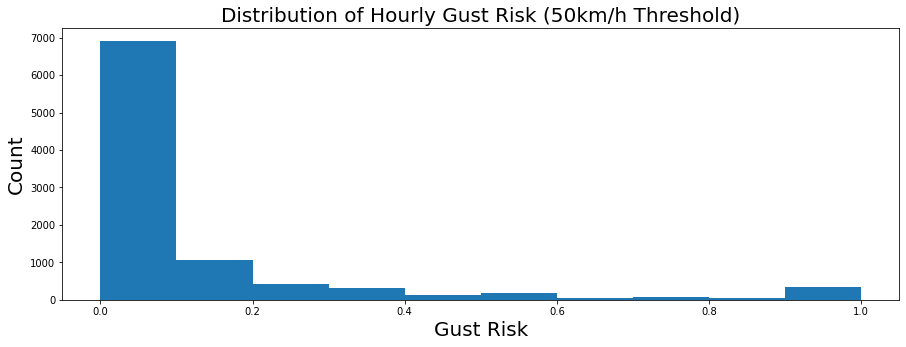

In [8]:
fig = plt.figure(figsize=(15,5))
plt.hist(cl.gust_risk)
plt.title('Distribution of Hourly Gust Risk (50km/h Threshold)',size=20)
plt.xlabel('Gust Risk',size=20)
plt.ylabel('Count',size=20)
plt.show()

In [9]:
def NSPP():
    """
    Function applies thinning algorithm for Non-Stationary Poisson Process using MaxLambda and Lambda parameters
    """
    PossibleArrival = SimClasses.Clock + SimRNG.Expon(1/(MaxLambda/60), 1)
    #Hour = np.floor(SimClasses.Clock/60).astype(int)
    while SimRNG.Uniform(0, 1, 3) >= (Lambda[Hour]/MaxLambda):
        PossibleArrival = PossibleArrival + SimRNG.Expon(1/(MaxLambda/60), 1)
    nspp = PossibleArrival - SimClasses.Clock
    return nspp

In [23]:
thinning = []
MaxLambda = 20 # per hour
Lambda = {0:12,1:14,2:16,3:18,4:20,5:18,6:16,7:14}
for i in range(0,8):
    thinning.append(Lambda[i]/MaxLambda)
    #for n in range(0,10000):
    #    Hour = i
    #    arrivals[Hour].append(NSPP())
    #np.sort(arrivals[i])

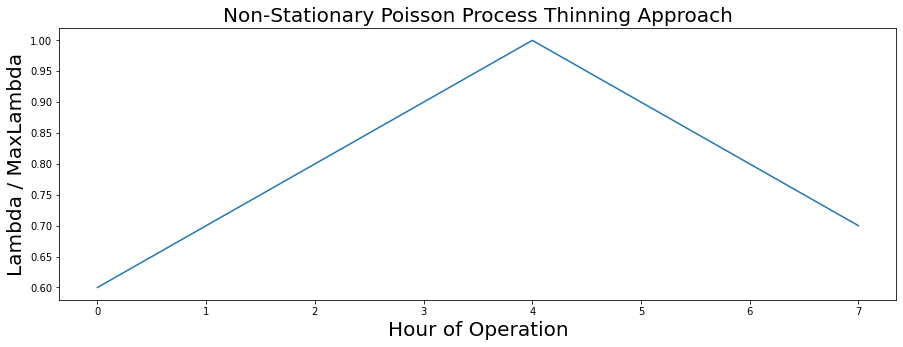

In [28]:
fig = plt.figure(figsize=(15,5))
plt.plot(thinning)
plt.title('Non-Stationary Poisson Process Thinning Approach',size=20)
plt.xlabel('Hour of Operation',size=20)
plt.ylabel('Lambda / MaxLambda',size=20)
plt.show()

In [9]:
def sample_gust(n_samples):
    """
    Samples the gust risk n times depending on the duration of the trip
    """
    rand = []
    for sample in range(n_samples):
        rand.append(SimRNG.Uniform(0,1,3))
    return min(rand)

def binomial_prob(service_time,gust_risk):
    """
    Determines the probability of 0 gusts occuring over the duration of the delivery
    """
    n = max(int(np.floor(service_time / 10)),1)
    p = gust_risk
    risk = (1-p)**n
    return risk, n

In [10]:
class WeatherClass():
    def __init__(self,weather_data):
        """
        Class for loading weather data, forecasting the weather conditions for a day and updating the weather state for the system
        """
        self.data = weather_data
        self.forecast = None
        self.state = None
    def Forecast(self,**args):
        self.operating_hours = args['operating_hours']
        if (args['type'] == 'historical') | (args['type'] == 'historical_day') | (args['type'] == 'inclement'):
            # Pull a historical weather day from the dataset
            self.forecast = list(self.data.loc[(self.data.year==args['year'])&(self.data.month==args['month'])&(self.data.day==args['day'])&(self.data.hour.isin(args['operating_hours'])),['hour','windspd','winddir','precip','gust_risk']].values)
        elif args['type'] == 'manual':
            # Pull an arbitray weather day and overwrite the weather conditions with the specified conditions
            temp = self.data.loc[(self.data.year==2020)&(self.data.month==6)&(self.data.day==4)&(self.data.hour.isin(args['operating_hours'])),['hour','windspd','winddir','precip','gust_risk']].copy()
            temp['windspd'] = args['windspd']
            temp['winddir'] = args['winddir']
            temp['precip'] = args['precip']
            temp['gust_risk'] = temp['windspd'].apply(lambda x: probgust(x,threshold,G_bar,G_sigma))
            self.forecast = list(temp.values)
    def Update(self,Queue,MeanST,Phases,drone_speed):
        hour, windspd, winddir, precip, gust_risk = self.forecast.pop(0) # Remove the latest row from the forecast
        self.state = {'windspd':windspd,'winddir':winddir,'precip':precip,'gust_risk':gust_risk} # Update the system weather state
        if Queue.NumQueue() > 0: # If the Queue has remaining customers update their attributes (service time / gust risk can change based on new windspd conditions)
            for i,Cust in enumerate(Queue.ThisQueue):
                Queue.ThisQueue[i].service_time = ServiceTime(Cust.distance,wind_speed=self.state['windspd'],wind_dir=self.state['winddir'],MeanST=MeanST,Phases=Phases,drone_speed=drone_speed)
                Queue.ThisQueue[i].risk,_ = binomial_prob(Cust.service_time,self.state['gust_risk'])
    def Schedule(self,Calendar):
        # Schedule hourly weather updates on the Calendar
        for i,hr in enumerate(self.operating_hours):
            update_time = i*60
            SimFunctions.Schedule(Calendar,"UpdateWeather",update_time)    

class DeliveriesClass(object):
    def __init__(self):
        """
        Class for logging delivery metrics (number completed, distance, coordinates, number of lost drones, number of delays, etc.)
        """
        self.coord = []
        self.distance = []
        self.service_time = []
        self.gust_risk = []
        self.wait = []
        self.status = []
        self.data = None
        self.N = 0
        self.delayed = 0
        self.lost = 0
    def Update(self,coord,distance,service_time,gust_risk,wait,status):
        self.coord.append(coord)
        self.distance.append(distance)
        self.service_time.append(service_time)
        self.gust_risk.append(gust_risk)
        self.wait.append(wait)
        self.status.append(status)    
        if status == 'Completed':
            self.N +=1  
        if status == 'Failed':
            self.lost +=1
    def Dataframe(self):
        # Convert to a dataframe
        self.data = pd.DataFrame((self.coord,self.distance,self.gust_risk,self.wait,self.status)).T
        self.data.columns = ['coord','distance','gust_risk','wait','status']

# 2. Simulation

In [11]:
def UAVSim(n_reps=1,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**args):
    # Initialize Random Seeds
    ZSimRNG = SimRNG.InitializeRNSeed()
    np.random.seed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []
    Deliveries = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    drone_speed = 80 # kmh
    MaxLambda = args['MaxLambda'] # For thinning function
    Lambda = args['Lambda'] # For thinning function
    MeanST = 5 # For actual delivery service (drone landing, customer receiving package, etc.)
    Phases = 2

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []
    AllDeliveries = []
    AllDelayedDrones = []
    AllLostDrones = []
    AllCompletedDeliveries = []

    def NSPP():
        """
        Function applies thinning algorithm for Non-Stationary Poisson Process using MaxLambda and Lambda parameters
        """
        PossibleArrival = SimClasses.Clock + SimRNG.Expon(1/(MaxLambda/60), 1)
        Hour = np.floor(SimClasses.Clock/60).astype(int)
        while SimRNG.Uniform(0, 1, 3) >= (Lambda[Hour]/MaxLambda):
            PossibleArrival = PossibleArrival + SimRNG.Expon(1/(MaxLambda/60), 1)
        nspp = PossibleArrival - SimClasses.Clock
        return nspp

    def Arrival():
        # Schedule next arrival with exponential distribution
        SimFunctions.Schedule(Calendar,"Arrival",NSPP())
        # Define New Customer - Sample from Geography, Calculate Distance and Service Time
        coord = sample_geo()
        distance = haversine(dc,coord)
        service_time = ServiceTime(distance,wind_speed=Weather.state['windspd'],wind_dir=Weather.state['winddir'],MeanST=MeanST,Phases=Phases,drone_speed=drone_speed)
        # Determine probability of 0 gusts occuring over duration of delivery (n_samples is the number of 10 minute intervals elapsed by the delivery)
        risk, n_samples = binomial_prob(service_time,Weather.state['gust_risk'])
        # Define new Customer entity using coord, distance, service_time, binomial risk
        Customer = SimClasses.Entity(coord,distance,service_time,risk)
        # Separately create a list of the Customer data for the policy functions
        Queue_Data.append([Customer.distance,Customer.service_time,Customer.risk,Customer.CreateTime])
        # Add Customer to the Queue
        Queue.Add(Customer)
        # Pass Customer / Queue / Server / Weather metrics into the Policy Function
        PolicyDecision = args['policy'](Queue_Data,Server,Weather)
        if PolicyDecision!='Delay': 
            # Remove Customer from Queue for Delivery
            CustomerEnteringService = Queue.Pop(PolicyDecision)
            Queue_Data.pop(PolicyDecision)
            # Record Time Spent in Queue
            WaitTime = SimClasses.Clock - CustomerEnteringService.CreateTime
            # Sample Uniform for Gust Prob
            U = sample_gust(n_samples)
            if U <= Weather.state['gust_risk']:
                # Drone is hit with a wind gust and forced to land.  Record failed delivery, subtract a drone from the total number available 
                Deliveries.Update(CustomerEnteringService.coord,CustomerEnteringService.distance,CustomerEnteringService.service_time,Weather.state['gust_risk'],WaitTime,"Failed")
                Server.NumberOfUnits -=1
                if Server.NumberOfUnits == 0:
                    SimFunctions.Schedule(Calendar,"LostAllDrones",0)
            else:
                # Drone is not hit with a wind gust and the delivery is successful.  Seize a drone and schedule the EndOfService
                Deliveries.Update(CustomerEnteringService.coord,CustomerEnteringService.distance,CustomerEnteringService.service_time,Weather.state['gust_risk'],WaitTime,"Completed")
                Server.Seize(1)
                service_time = CustomerEnteringService.service_time
                SimFunctions.Schedule(Calendar,"EndOfService",service_time)
        else: 
            # Cannot send a drone due to policy
            Deliveries.delayed +=1
            SimFunctions.Schedule(Calendar,"EndOfService",60)

    def EndOfService():
        if Queue.NumQueue() > 0: # Queue is longer than 0.  Check policy to see if we can send a new drone
            PolicyDecision = args['policy'](Queue_Data,Server,Weather)
            if PolicyDecision!='Delay': 
                # Remove Customer from Queue for Delivery
                CustomerEnteringService = Queue.Pop(PolicyDecision)
                Queue_Data.pop(PolicyDecision)
                # Record Time Spent in Queue
                n_samples = max(round(CustomerEnteringService.service_time / 10),1)
                # Record Time Spent in Queue
                WaitTime = SimClasses.Clock - CustomerEnteringService.CreateTime
                # Sample Uniform for Gust Prob
                U = sample_gust(n_samples)
                if U <= Weather.state['gust_risk']:
                    # Drone is hit with a wind gust and forced to land.  Record failed delivery, subtract a drone from the total number available
                    Deliveries.Update(CustomerEnteringService.coord,CustomerEnteringService.distance,CustomerEnteringService.service_time,Weather.state['gust_risk'],WaitTime,"Failed")
                    Server.NumberOfUnits -=1
                    if Server.NumberOfUnits == 0:
                        SimFunctions.Schedule(Calendar,"LostAllDrones",0)
                else:
                    # Drone is not hit with a wind gust and the delivery is successful.  Seize a drone and schedule the EndOfService
                    Deliveries.Update(CustomerEnteringService.coord,CustomerEnteringService.distance,CustomerEnteringService.service_time,Weather.state['gust_risk'],WaitTime,"Completed")
                    Server.Seize(1)
                    service_time = CustomerEnteringService.service_time
                    SimFunctions.Schedule(Calendar,"EndOfService",service_time)
            else:
                # Cannot send a drone due to policy
                Deliveries.delayed +=1
                SimFunctions.Schedule(Calendar,"EndOfService",60)
        else:
            # No customers to serve, can free up a drone
            Server.Free(1)

    def UpdateWeather(Queue):
        """ 
        Updates the weather state of the system
        """
        Weather.Update(Queue,MeanST,Phases,drone_speed)

    def print_system_state():
        """
        For debugging: can print the system state and track the state transitions of the discrete event simulation
        """
        event = NextEvent.EventType
        clock = SimClasses.Clock
        windspd = Weather.state['windspd']
        gust = Weather.state['gust_risk']
        busy = Server.Busy
        totdrone = Server.NumberOfUnits
        qlen = Queue.NumQueue()
        print((event,"Clock",clock,"Windspd",windspd,"Gust",gust,"BusyDrones",busy,"TotDrones",totdrone,"QueueLength",qlen))
    
    if args['type'] == 'inclement':
        # Check passed arguments, if they call for inclement weather filter the weather data on days where gust risk exceeds 50% within the operating hours of the system
        ymd = cl.loc[(cl.gust_risk>0.5)&(cl.hour.isin([9,10,11,12,13,14,15,16,17])),['year','month','day','windspd','winddir','precip']].dropna()[['year','month','day']].drop_duplicates().values
        weather_args = {'type':'inclement','operating_hours':[9,10,11,12,13,14,15,16,17]}
    else:
        # Otherwise pull the entire weather dataset for simulation
        ymd = cl[['year','month','day','windspd','winddir','precip']].dropna()[['year','month','day']].drop_duplicates().values
        weather_args = {'type':args['type'],'operating_hours':[9,10,11,12,13,14,15,16,17]}

    for reps in range(0,n_reps,1):
        weather_idx = reps % len(ymd) # Weather_idx is an index for the weather data, when n_reps exceeds the number of days, the mod math resets the index
        weather_args['year'], weather_args['month'], weather_args['day'] = ymd[weather_idx] # Set the yyyymmdd parameters for our weather arguments
        if args['type']=='manual': # If we are testing manual parameters override the winddir, windspd, precip values
            weather_args['winddir'] = args['winddir']
            weather_args['windspd'] = args['windspd']
            weather_args['precip'] = args['precip']
        
        Server.SetUnits(n_drones) # Reset number of drones each replication
        Queue_Data = [] # Reset queue data inbetween replications
        SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
        Weather = WeatherClass(cl) # Initialize weather class
        Weather.Forecast(**weather_args) # Forecast weather for this replication (using arguments specified above)
        Weather.Schedule(Calendar) # Schedule weather updates each hour
        Deliveries = DeliveriesClass() # Initialize deliveries class for tracking delivery stats
        SimFunctions.Schedule(Calendar,"Arrival",NSPP()) # Schedule first arrival using NSPP function
        
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "UpdateWeather":
            UpdateWeather(Queue)
        elif NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService() 
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats,TheDTStats)

        while len(Weather.forecast)>0: # While we are within the operating hours of the system

            NextEvent = Calendar.Remove()

            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "UpdateWeather":
                UpdateWeather(Queue)
            elif NextEvent.EventType == "Arrival":
                #print_system_state()
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                #print_system_state()
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats,TheDTStats)
            elif NextEvent.EventType == "LostAllDrones":
                break

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())
        AllDeliveries.append(Deliveries)
        AllDelayedDrones.append(Deliveries.delayed)
        AllLostDrones.append(Deliveries.lost)
        AllCompletedDeliveries.append(Deliveries.N)

    if verbose:
        print("Estimated Expected Average wait: %.2f" % np.mean(AllWaitMean))
        print("Estimated Expected Average queue-length: %.2f" % np.mean(AllQueueMean))
        print("Estimated Expected Average utilization: %.2f" % np.mean(AllServerMean))
        print("Estimated Expected Number of Delayed Drones: %.2f" % np.mean(AllDelayedDrones))
        print("Estimated Expected Number of Lost Drones: %.2f" % np.mean(AllLostDrones))

    return AllDeliveries,AllCompletedDeliveries,AllLostDrones,AllQueueMean

In [12]:
def t_mean_confidence_interval(data,alpha):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = stats.t.ppf(1-alpha/2, n-1)*se
    return m, h

In [13]:
# Example of Simulation Call
MaxLambda = 20 # per hour
Lambda = {0:12,1:14,2:16,3:18,4:20,5:18,6:16,7:14}
arguments = {'type':'inclement','operating_hours':[9,10,11,12,13,14,15,16,17],'MaxLambda':MaxLambda,'Lambda':Lambda}
def policy0(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits: # Naive Policy: Always Send Drone
        return 0 
    else:
        return 'Delay'
arguments['policy'] = policy0
d,res,lost,queue = UAVSim(n_reps=1,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**arguments)

  # System Dynamics

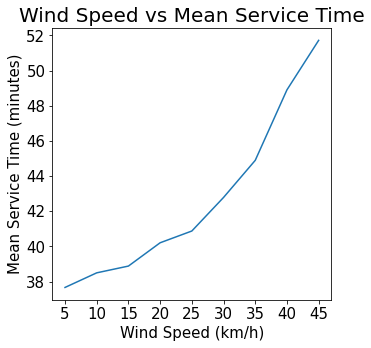

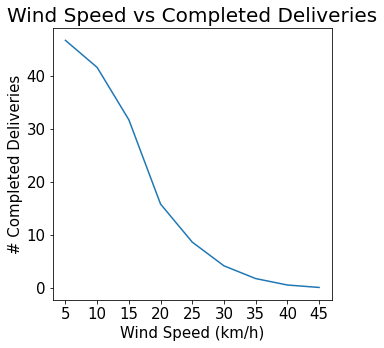

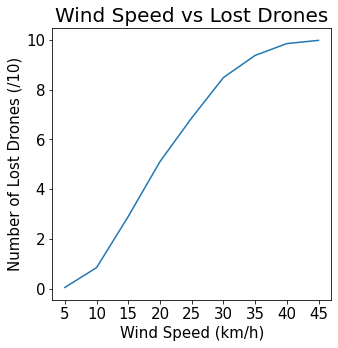

In [14]:
resST = {}
resND = {}
resLD = {}
MaxLambda = 10
#Lambda = {0:6,1:7,2:8,3:9,4:10,5:9,6:8,7:7}
Lambda = {0:1/(6/60),1:1/(7/60),2:1/(8/60),3:1/(9/60),4:1/(10/60),5:1/(9/60),6:1/(8/60),7:1/(7/60)}
for windspd in np.arange(5,50,5):
  args = {'type':'manual','windspd':windspd,'winddir':0,'precip':0,'operating_hours':[9,10,11,12,13,14,15,16,17],'MaxLambda':MaxLambda,'Lambda':Lambda,'policy':policy0}
  deliveries,results,lost,queue = UAVSim(n_reps=500,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**args)
  resST[windspd] = np.mean([np.mean(x.service_time) for x in deliveries])
  resND[windspd] = np.mean([np.mean(x.N) for x in deliveries])
  resLD[windspd] = np.mean([np.mean(x.lost) for x in deliveries])
dfST = pd.DataFrame.from_dict(resST,orient='index').reset_index()
dfND = pd.DataFrame.from_dict(resND,orient='index').reset_index()
dfLD = pd.DataFrame.from_dict(resLD,orient='index').reset_index()

fig = plt.figure(figsize=(5,5))
plt.plot(dfST['index'],dfST[0])
plt.title("Wind Speed vs Mean Service Time",size=20)
plt.xlabel("Wind Speed (km/h)",size=15)
plt.ylabel("Mean Service Time (minutes)",size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

fig = plt.figure(figsize=(5,5))
plt.plot(dfND['index'],dfND[0])
plt.title("Wind Speed vs Completed Deliveries",size=20)
plt.xlabel("Wind Speed (km/h)",size=15)
plt.ylabel("# Completed Deliveries",size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

fig = plt.figure(figsize=(5,5))
plt.plot(dfLD['index'],dfLD[0])
plt.title("Wind Speed vs Lost Drones",size=20)
plt.xlabel("Wind Speed (km/h)",size=15)
plt.ylabel("Number of Lost Drones (/10)",size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

## Policy Definitions

In [34]:
def policy0(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits: # Naive Policy: Always Send Drone
        return 0 
    else:
        return 'Delay'

def policy1(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            return qd[:,2].argsort()[-1] # Minimum Binomial Risk Policy
        else:
            return 0
    else:
        return 'Delay'

def policy2(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.5: # Minimum Binomial Risk if >50% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy3(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.25: # Minimum Binomial Risk if >25% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy4(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            return qd[:,0].argsort()[0] # Shortest Distance Available Policy
        else:
            return 0
    else:
        return 'Delay'

def policy5(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,0].argsort()[0]
            if qd[idx,0] <= 10: # Shortest Distance Available if < 10km Distance
                return idx
            else:
                return 'Delay'
        else:
            return 'Delay'
    else:
        return 'Delay'

def policy6(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,0].argsort()[0]
            if qd[idx,0] <= 40: # Shortest Distance Available if < 40km Distance
                return idx
            else:
                return 'Delay'
        else:
            return 'Delay'
    else:
        return 'Delay'

def policy7(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.40: # Minimum Binomial Risk if >40% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy8(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.30: # Minimum Binomial Risk if >30% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy9(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.60: # Minimum Binomial Risk if >10% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy10(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.70: # Minimum Binomial Risk if >10% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'

def policy11(Queue_Data,Server,Weather):
    if Server.Busy < Server.NumberOfUnits:
        if len(Queue_Data) > 0:
            qd = np.array(Queue_Data)
            idx = qd[:,2].argsort()[-1]
            if qd[idx,2] > 0.80: # Minimum Binomial Risk if >10% Probability of 0 Gusts
                return idx
            else:
                return 'Delay'
        else:
            return 0
    else:
        return 'Delay'
      
policies = [policy0,policy1,policy2,policy3,policy4,policy5,policy6]
policies = [policy7,policy2,policy9,policy10]

## Subset Selection: All Historical Weather

In [16]:
# Parameters
MaxLambda = 20 # per hour
Lambda = {0:12,1:14,2:16,3:18,4:20,5:18,6:16,7:14}
arguments = {'type':'historical','operating_hours':[9,10,11,12,13,14,15,16,17],'MaxLambda':MaxLambda,'Lambda':Lambda}
policies = [policy0,policy1,policy2,policy3,policy4,policy5,policy6]
# Subset Selection Variables
K = len(policies)
results = {}
deliveries = {}
lost = {}
queue = {}
t_quantiles = {}
sample_means_deliveries = {}
sample_means_lost = {}
ci_deliveries = {}
ci_lost = {}
sample_vars_deliveries = {}
sample_vars_lost = {}
n_reps = 1000
# Loop Through Policies
for p in policies:
    arguments['policy'] = p
    deliveries[str(p)],results[str(p)],lost[str(p)],queue[str(p)] = UAVSim(n_reps=n_reps,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**arguments)
    # Calculate t quantiles @ 95% confidence
    t_quantiles[str(p)] = stats.t.ppf((1-0.05)**(1/(K-1)), n_reps-1)
    # Calculate sample means and variances for the number of completed deliveries
    sample_means_deliveries[str(p)] = np.mean(results[str(p)])
    ci_deliveries[str(p)] = t_mean_confidence_interval(results[str(p)],0.05)
    sample_vars_deliveries[str(p)] = np.var(results[str(p)],ddof=1)
    # Calculate sample means and variances for the number of lost drones
    sample_means_lost[str(p)] = np.mean(lost[str(p)])
    ci_lost[str(p)] = t_mean_confidence_interval(lost[str(p)],0.05)
    sample_vars_lost[str(p)] = np.var(lost[str(p)],ddof=1)

In [17]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Deliveries)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_deliveries[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_deliveries[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_deliveries[h_]/n_reps))
            means.append(sample_means_deliveries[h_] - W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[-1]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy0 at 0x7fabf3303a70>', '<function policy1 at 0x7fabf49d7b00>', '<function policy2 at 0x7fabf3303830>', '<function policy3 at 0x7fabf3096ef0>', '<function policy4 at 0x7fabf3096f80>']


In [18]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Lost Drones)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_lost[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_lost[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_lost[h_]/n_reps))
            means.append(sample_means_lost[h_] + W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[0]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy5 at 0x7fabf27370e0>']


In [19]:
ci_deliveries

{'<function policy0 at 0x7fabf3303a70>': (14.99, 0.5290488031343324),
 '<function policy1 at 0x7fabf49d7b00>': (14.837, 0.5434343997054456),
 '<function policy2 at 0x7fabf3303830>': (14.828, 0.483951906522373),
 '<function policy3 at 0x7fabf3096ef0>': (15.177, 0.5213045806788911),
 '<function policy4 at 0x7fabf3096f80>': (14.958, 0.5360564444910638),
 '<function policy5 at 0x7fabf27370e0>': (8.782, 0.12498332133792583),
 '<function policy6 at 0x7fabf2737290>': (10.258, 0.315585138100231)}

In [20]:
ci_lost

{'<function policy0 at 0x7fabf3303a70>': (2.882, 0.19099893487697206),
 '<function policy1 at 0x7fabf49d7b00>': (2.916, 0.1920140693161783),
 '<function policy2 at 0x7fabf3303830>': (1.682, 0.10142757306705857),
 '<function policy3 at 0x7fabf3096ef0>': (2.293, 0.13558522694688868),
 '<function policy4 at 0x7fabf3096f80>': (2.923, 0.19243644971188087),
 '<function policy5 at 0x7fabf27370e0>': (1.243, 0.12423278259875492),
 '<function policy6 at 0x7fabf2737290>': (2.093, 0.1741540980464996)}

## Subset Selection: Inclement Weather

In [21]:
# Parameters
MaxLambda = 20 # per hour
Lambda = {0:12,1:14,2:16,3:18,4:20,5:18,6:16,7:14}
arguments = {'type':'inclement','operating_hours':[9,10,11,12,13,14,15,16,17],'MaxLambda':MaxLambda,'Lambda':Lambda}
policies = [policy0,policy1,policy2,policy3,policy4,policy5,policy6]
# Subset Selection Variables
K = len(policies)
results = {}
deliveries = {}
lost = {}
queue = {}
t_quantiles = {}
sample_means_deliveries = {}
sample_means_lost = {}
ci_deliveries = {}
ci_lost = {}
sample_vars_deliveries = {}
sample_vars_lost = {}
n_reps = 1000
# Loop Through Policies
for p in policies:
    arguments['policy'] = p
    deliveries[str(p)],results[str(p)],lost[str(p)],queue[str(p)] = UAVSim(n_reps=n_reps,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**arguments)
    # Calculate t quantiles @ 95% confidence
    t_quantiles[str(p)] = stats.t.ppf((1-0.05)**(1/(K-1)), n_reps-1)
    # Calculate sample means and variances for the number of completed deliveries
    sample_means_deliveries[str(p)] = np.mean(results[str(p)])
    ci_deliveries[str(p)] = t_mean_confidence_interval(results[str(p)],0.05)
    sample_vars_deliveries[str(p)] = np.var(results[str(p)],ddof=1)
    # Calculate sample means and variances for the number of lost drones
    sample_means_lost[str(p)] = np.mean(lost[str(p)])
    ci_lost[str(p)] = t_mean_confidence_interval(lost[str(p)],0.05)
    sample_vars_lost[str(p)] = np.var(lost[str(p)],ddof=1)

In [22]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Deliveries)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_deliveries[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_deliveries[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_deliveries[h_]/n_reps))
            means.append(sample_means_deliveries[h_] - W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[-1]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy2 at 0x7fabf3303830>', '<function policy3 at 0x7fabf3096ef0>', '<function policy4 at 0x7fabf3096f80>']


In [23]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Lost Drones)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_lost[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_lost[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_lost[h_]/n_reps))
            means.append(sample_means_lost[h_] + W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[0]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy2 at 0x7fabf3303830>']


In [24]:
ci_deliveries

{'<function policy0 at 0x7fabf3303a70>': (8.557, 0.46256478135224055),
 '<function policy1 at 0x7fabf49d7b00>': (8.46, 0.4519073992150224),
 '<function policy2 at 0x7fabf3303830>': (9.51, 0.4094548423502752),
 '<function policy3 at 0x7fabf3096ef0>': (9.461, 0.41940042583532927),
 '<function policy4 at 0x7fabf3096f80>': (8.825, 0.4641853473304814),
 '<function policy5 at 0x7fabf27370e0>': (6.499, 0.17704778348471553),
 '<function policy6 at 0x7fabf2737290>': (6.728, 0.31338242638446495)}

In [25]:
ci_lost

{'<function policy0 at 0x7fabf3303a70>': (6.01, 0.207201785237756),
 '<function policy1 at 0x7fabf49d7b00>': (5.979, 0.20726371569687507),
 '<function policy2 at 0x7fabf3303830>': (2.564, 0.1103992634123099),
 '<function policy3 at 0x7fabf3096ef0>': (3.921, 0.14076849194765617),
 '<function policy4 at 0x7fabf3096f80>': (5.909, 0.20580947732662033),
 '<function policy5 at 0x7fabf27370e0>': (3.53, 0.1760773810448607),
 '<function policy6 at 0x7fabf2737290>': (4.851, 0.216667647147745)}

## Subset Selection: Refined 5000 Replications

In [35]:
# Parameters
MaxLambda = 20 # per hour
Lambda = {0:12,1:14,2:16,3:18,4:20,5:18,6:16,7:14}
arguments = {'type':'inclement','operating_hours':[9,10,11,12,13,14,15,16,17],'MaxLambda':MaxLambda,'Lambda':Lambda}
policies = [policy8,policy7,policy2,policy9,policy10] # 30,40,50,60,70
# Subset Selection Variables
K = len(policies)
results = {}
deliveries = {}
lost = {}
queue = {}
t_quantiles = {}
sample_means_deliveries = {}
sample_means_lost = {}
ci_deliveries = {}
ci_lost = {}
sample_vars_deliveries = {}
sample_vars_lost = {}
n_reps = 10000
# Loop Through Policies
for p in policies:
    arguments['policy'] = p
    deliveries[str(p)],results[str(p)],lost[str(p)],queue[str(p)] = UAVSim(n_reps=n_reps,n_drones=10,dc=np.array([43.74767,-79.40574]),verbose=False,**arguments)
    # Calculate t quantiles @ 95% confidence
    t_quantiles[str(p)] = stats.t.ppf((1-0.05)**(1/(K-1)), n_reps-1)
    # Calculate sample means and variances for the number of completed deliveries
    sample_means_deliveries[str(p)] = np.mean(results[str(p)])
    ci_deliveries[str(p)] = t_mean_confidence_interval(results[str(p)],0.05)
    sample_vars_deliveries[str(p)] = np.var(results[str(p)],ddof=1)
    # Calculate sample means and variances for the number of lost drones
    sample_means_lost[str(p)] = np.mean(lost[str(p)])
    ci_lost[str(p)] = t_mean_confidence_interval(lost[str(p)],0.05)
    sample_vars_lost[str(p)] = np.var(lost[str(p)],ddof=1)

In [36]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Deliveries)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_deliveries[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_deliveries[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_deliveries[h_]/n_reps))
            means.append(sample_means_deliveries[h_] - W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[-1]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy8 at 0x7fabf2737320>', '<function policy7 at 0x7fabef4034d0>', '<function policy2 at 0x7fabf3591d40>']


In [37]:
# Calculate Subset W Threshold Values and Compare Policies to Determine the Optimum Subset (For Number of Lost Drones)
W = {}
subset = []
for i,policy_i in enumerate(policies):
    i_ = str(policy_i)
    W[i_] = {}
    means = [sample_means_lost[i_]]
    policies_ = [i_]
    for h,policy_h in enumerate(policies):
        h_ = str(policy_h)
        if h_ != i_:
            W[i_][h_] = np.sqrt((t_quantiles[i_]**2)*(sample_vars_lost[i_]/n_reps) + (t_quantiles[h_]**2)*(sample_vars_lost[h_]/n_reps))
            means.append(sample_means_lost[h_] + W[i_][h_])
            policies_.append(h_)   
  
    max_idx = np.array(means).argsort()[0]
    if i_ == policies_[max_idx]:
        subset.append(i_)

print(subset)

['<function policy10 at 0x7fabef3f00e0>']


In [38]:
ci_deliveries

{'<function policy10 at 0x7fabef3f00e0>': (8.5613, 0.12492635626541837),
 '<function policy2 at 0x7fabf3591d40>': (9.42, 0.12376026244289205),
 '<function policy7 at 0x7fabef4034d0>': (9.4541, 0.12525483038319735),
 '<function policy8 at 0x7fabf2737320>': (9.4046, 0.1285315169185542),
 '<function policy9 at 0x7fabef3f0200>': (9.2276, 0.1215145207903456)}

In [39]:
ci_lost

{'<function policy10 at 0x7fabef3f00e0>': (1.3001, 0.025093668433970377),
 '<function policy2 at 0x7fabf3591d40>': (2.5545, 0.03381973489989752),
 '<function policy7 at 0x7fabef4034d0>': (3.1616, 0.0380383204773595),
 '<function policy8 at 0x7fabf2737320>': (3.691, 0.04205707324914111),
 '<function policy9 at 0x7fabef3f0200>': (1.9903, 0.029911147488632835)}

## Plot Coords

In [40]:
def plot_deliveries(deliveries_instance,dc):
    Coord = []
    for d in deliveries_instance: 
        Coord+=d.coord
    Coord = pd.DataFrame(Coord,columns=['lat','long'])
    Coord['type'] = 'delivery'
    Coord['size'] = 0.5
    Coord = Coord.append(pd.DataFrame([list(dc)+['dc',5]],columns=['lat','long','type','size']))
    Coord['Count'] = 1
    Coord = Coord.groupby(by=['lat','long','type','size'])['Count'].sum().reset_index()
    fig = px.scatter_mapbox(Coord,lat='lat',lon='long',color='type',size='size',hover_data=['Count'],zoom=12,width=1000,height=1000)
    fig.show()

In [41]:
coord = plot_deliveries(deliveries["<function policy2 at 0x7fabf3591d40>"],dc)